## 1. Import Module

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from rdkit.Chem import PandasTools
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Descriptors import MolLogP
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import Descriptors
import sys
import multiprocessing
from standardiser import break_bonds, neutralise, rules, unsalt
from standardiser.utils import StandardiseException, sanity_check
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import joblib
import sys
def warn(*args, **kwargs):
    pass  # to suppress sklearn warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn
from rdkit.Chem.Descriptors import MolLogP
from rdkit.Chem import Descriptors
from tools import tools
from tools import  pipeline as p
from tools import  sar
from sklearn.metrics import cohen_kappa_score
import csv
from rdkit.Chem import MACCSkeys
from sklearn.model_selection import ShuffleSplit
import _pickle as cPickle
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
import bz2
from glob import glob
import _pickle as cPickle
import pickle
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import train_test_split

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


  * could not import Bokeh, plotting with Highcharts instead.
- no local installation of highcharts found, using web version.
- loading highcharts...


* SA scorer not available. RDKit's Contrib dir needs to be in the Python import path...
tools.tools                                   (211209-10:18)
- no local installation of JSME found, using web version.
* SA scorer not available. RDKit's Contrib dir needs to be in the Python import path...
> interactive IPython session.
tools.sar                                     (211209-10:18)


## 2. Load sdf file 

In [3]:
#Caminho do SDF
file= "E:/stoptox-master/stoptox-master/modeling/Projeto_2_Acute_Inhalation/data/train_set_toxic.sdf"

sdfInfo = dict(smilesName='SMILES',molColName='ROMol')
moldf = PandasTools.LoadSDF(file,**sdfInfo)
#Rename ROMol
moldf = moldf.rename(columns={'ROMol': 'Mol'})
#duplicatas by smiles
moldf = moldf.drop_duplicates(subset=['SMILES'])
 RDKit
moldf = moldf[pd.notnull(moldf['Mol'])]
#Colunas no pandas
moldf.keys()

Failed to patch pandas - unable to change molecule rendering


Index(['id', 'casrn', 'smiles (First)', 'Molecular weight', 'name', 'Outcome',
       'Molecule (RDKit Mol) (InChI Code)', 'reference', 'molecule_form', 'ID',
       'SMILES', 'Mol'],
      dtype='object')

In [7]:
moldf = moldf[['ID','Mol', 'SMILES','Outcome']]
moldf = moldf[(moldf['Outcome']== '0')|(moldf['Outcome']== '1')]
print(moldf.shape)
moldf.head()
moldf.Outcome=pd.to_numeric(moldf.Outcome, errors='coerce')
moldf.info()

(541, 4)
<class 'pandas.core.frame.DataFrame'>
Index: 541 entries, 0 to 540
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID       541 non-null    object
 1   Mol      541 non-null    object
 2   SMILES   541 non-null    object
 3   Outcome  541 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 21.1+ KB


In [8]:
moldf.head(1)

,ID,Mol,SMILES,Outcome
0,,<rdkit.Chem.rdchem.Mol object at 0x000002547E8...,CC(C)c1cccc2c(C(C)C)cccc12,0


In [9]:
moldf= moldf.sort_values(['Outcome'], ascending=True)
moldf['RowID'] = moldf.index
moldf.head(300)

,ID,Mol,SMILES,Outcome,RowID
0,,<rdkit.Chem.rdchem.Mol object at 0x000002547E8...,CC(C)c1cccc2c(C(C)C)cccc12,0,0
491,,<rdkit.Chem.rdchem.Mol object at 0x000002547FA...,NC(=O)c1ccccc1N,0,491
492,,<rdkit.Chem.rdchem.Mol object at 0x000002547FA...,CCO[Si](OCC)(OCC)OCC,0,492
494,,<rdkit.Chem.rdchem.Mol object at 0x000002547FA...,FC(F)(F)C(Cl)(Cl)Cl,0,494
497,,<rdkit.Chem.rdchem.Mol object at 0x000002547FA...,CC(F)(F)Cl,0,497
...,...,...,...,...,...
281,,<rdkit.Chem.rdchem.Mol object at 0x000002547FA...,c1ccc2c(c1)CCNC2,1,281
284,,<rdkit.Chem.rdchem.Mol object at 0x000002547FA...,CC[Al](CC)CC,1,284
280,,<rdkit.Chem.rdchem.Mol object at 0x000002547FA...,C[N+](C)(C)CC1CO1,1,280
279,,<rdkit.Chem.rdchem.Mol object at 0x000002547FA...,CS,1,279


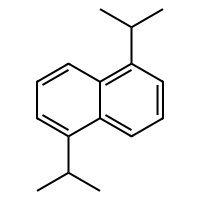

CC(C)c1cccc2c(C(C)C)cccc12


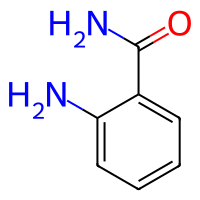

NC(=O)c1ccccc1N


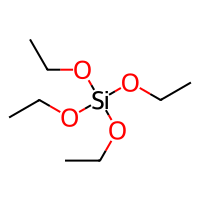

CCO[Si](OCC)(OCC)OCC


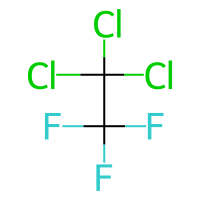

FC(F)(F)C(Cl)(Cl)Cl


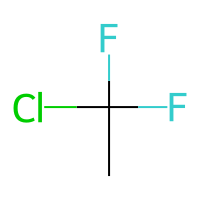

CC(F)(F)Cl


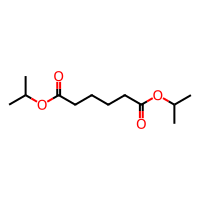

CC(C)OC(=O)CCCCC(=O)OC(C)C


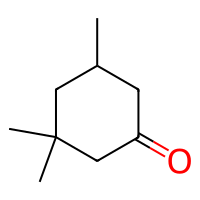

CC1CC(=O)CC(C)(C)C1


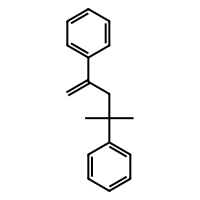

C=C(CC(C)(C)c1ccccc1)c1ccccc1


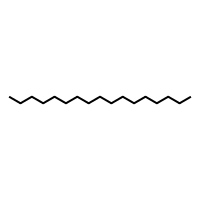

CCCCCCCCCCCCCCCCC


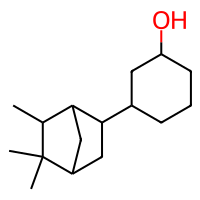

CC1C2CC(CC2C2CCCC(O)C2)C1(C)C


In [10]:
from rdkit.Chem import Draw
from IPython.display import display

def display_molecules_in_column(moldf, num_mols):
    for _, row in moldf.head(num_mols).iterrows():
        mol = row['Mol']
        smi = row['SMILES']
        if mol is not None:
            img = Draw.MolToImage(mol, size=(200, 200))
            display(img)
            print(smi)  # Prints the SMILES representation below the image

# Display the first 10 molecules, each on a new row
display_molecules_in_column(moldf, 10)


## Data distribution

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()


outcomes=(np.unique(moldf['Outcome']))
le.fit(list(set(outcomes)))
y = le.transform( moldf['Outcome'] )



print ("Classes                          : ",(outcomes))
print ("Number of cpds in each class     : ",np.unique([len(y[y==smi]) for smi in y]))
print ("Total number of cpds             : ",len(y))

S = moldf['Outcome']
info = {}
for i,cls in enumerate(S.unique()):
    info.update({cls:i})
    S = S.replace(cls,i)

Classes                          :  [0 1]
Number of cpds in each class     :  [259 282]
Total number of cpds             :  541


{0: 0, 1: 1}

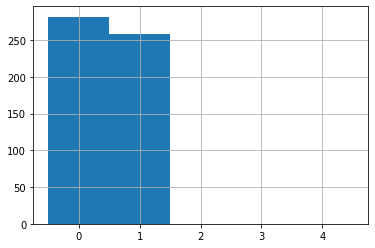

In [12]:
ax = S.hist(bins=np.arange(-0.5,5))
ax.set_xticks(range(0,5))
info

In [14]:
pip install mordred


     -------------------------------------- 128.8/128.8 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176725 sha256=0af1203e49c853d5740e64def76f81a92fd489cc3c922d0c0ba087735caf7159
  Stored in directory: c:\users\user-pc\appdata\local\pip\cache\wheels\05\95\d1\9e913738f0e8362b3676917b953a60afd76d2b0b99ff8a71ec
Successfully built mordred
Note: you may need to restart the kernel to use updated packages.


## 5.Modred calculation

In [13]:
from sklearn.preprocessing import StandardScaler
from rdkit import Chem
from mordred import Calculator, descriptors

# create descriptor calculator with all descriptors
calc = Calculator(descriptors, ignore_3D=True)
df = calc.pandas(moldf['Mol'])

 25%|██▍       | 134/541 [00:04<00:07, 56.97it/s]

C:\Users\USER-PC\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\USER-PC\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 32%|███▏      | 174/541 [00:05<00:06, 56.61it/s]

C:\Users\USER-PC\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 43%|████▎     | 231/541 [00:06<00:04, 76.09it/s]

C:\Users\USER-PC\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 541/541 [00:09<00:00, 58.10it/s] 


In [17]:
pip install fancyimpute


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 12.8/12.8 MB 10.4 MB/s eta 0:00:00
   ---------------------------------------- 1.0/1.0 MB 10.9 MB/s eta 0:00:00
   --------------------------------------- 321.5/321.5 kB 10.0 MB/s eta 0:00:00
   ---------------------------------------- 72.0/72.0 kB 3.9 MB/s eta 0:00:00
   ---------------------------------------- 293.1/293.1 kB 8.8 MB/s eta 0:00:00
   ---------------------------------------- 8.4/8.4 MB 8.7 MB/s eta 0:00:00
   ---------------------------------------- 235.0/235.0 kB 7.2 MB/s eta 0:00:00
   ---------------------------------------- 85.1/85.1 kB 5.0 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29899 sha256=4805bba81bc9cf541c63144bcfa7a0bd1c5b5c2a19150ef70a43086e861df091
  Stored

In [14]:
from fancyimpute import KNN
import pandas as pd
import numpy as np

# Assuming 'df' is your original DataFrame
df_numeric = df.select_dtypes(include=[float])  # Using Python's built-in float type

# Now run fancyimpute KNN, it returns a np.array which I store as a pandas dataframe
# Assuming the columns in df_numeric should be preserved for df_filled
df_filled = pd.DataFrame(KNN(k=3).fit_transform(df_numeric), columns=df_numeric.columns, index=df_numeric.index)


(CVXPY) Jun 02 05:18:59 PM: Encountered unexpected exception importing solver CVXOPT:
ImportError('DLL load failed while importing base: The specified module could not be found.')
(CVXPY) Jun 02 05:18:59 PM: Encountered unexpected exception importing solver GLPK:
ImportError('DLL load failed while importing base: The specified module could not be found.')
(CVXPY) Jun 02 05:18:59 PM: Encountered unexpected exception importing solver GLPK_MI:
ImportError('DLL load failed while importing base: The specified module could not be found.')
Imputing row 1/541 with 0 missing, elapsed time: 0.402
Imputing row 101/541 with 0 missing, elapsed time: 0.402
Imputing row 201/541 with 0 missing, elapsed time: 0.403
Imputing row 301/541 with 0 missing, elapsed time: 0.403
Imputing row 401/541 with 0 missing, elapsed time: 0.404
Imputing row 501/541 with 0 missing, elapsed time: 0.404


In [15]:
y= np.int32((S))
X = np.array(df_filled)
scaler = StandardScaler()
x=  scaler.fit_transform(X)
moldf['Descriptors'] = x.tolist()
moldf.head()

,ID,Mol,SMILES,Outcome,RowID,Descriptors
0,,<rdkit.Chem.rdchem.Mol object at 0x000002547E8...,CC(C)c1cccc2c(C(C)C)cccc12,0,0,"[0.5659596548561933, 1.1875118998698118, 1.255..."
491,,<rdkit.Chem.rdchem.Mol object at 0x000002547FA...,NC(=O)c1ccccc1N,0,491,"[-0.18718971751636582, 0.5594893095428105, 0.6..."
492,,<rdkit.Chem.rdchem.Mol object at 0x000002547FA...,CCO[Si](OCC)(OCC)OCC,0,492,"[0.07758842050474492, 0.6354612702770022, 0.69..."
494,,<rdkit.Chem.rdchem.Mol object at 0x000002547FA...,FC(F)(F)C(Cl)(Cl)Cl,0,494,"[-0.6249143890319181, 0.6878726171195476, 0.74..."
497,,<rdkit.Chem.rdchem.Mol object at 0x000002547FA...,CC(F)(F)Cl,0,497,"[-0.9217807513882242, -0.4042712276941926, -0...."


In [16]:
print(x.shape)

(541, 739)


In [17]:
num_features = x.shape[1]
print(num_features)


739


In [18]:
from sklearn.metrics import make_scorer, cohen_kappa_score
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
# Define your parameter grid as before
paramgrid = {
    "max_features": [
        x.shape[1], x.shape[1] // 2, x.shape[1] // 4, x.shape[1] // 12, x.shape[1] // 10,
        x.shape[1] // 7, x.shape[1] // 5, x.shape[1] // 3
    ],
    "n_estimators": [10, 100, 300, 500],
}

# Define the cross-validator as before
cv = StratifiedShuffleSplit(n_splits=2, test_size=0.5, random_state=24)

# Define the scoring function using Cohen's Kappa Score with quadratic weighting
kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

# Everything else remains the same in your GridSearchCV initialization and fitting
model = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced'),
                     param_grid=paramgrid,
                     scoring=kappa_scorer,
                     cv=cv,
                     verbose=1,
                     n_jobs=1)  # Use -1 to use all cores

# Fit the model
model.fit(x, y)

# Get the best model
best_model = model.best_estimator_

# Optionally, fit the model with the best parameters (GridSearchCV automatically does this)
# best_model.fit(x, y)


Fitting 2 folds for each of 32 candidates, totalling 64 fits


In [32]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, cohen_kappa_score

# Define your parameter grid
paramgrid = {
    "max_depth": [3, 5, 7, 10],  # Common choices for tree depth
    "n_estimators": [100, 200, 300],  # Number of trees
    "learning_rate": [0.01, 0.1, 0.2]  # Step size shrinkage used to prevent overfitting
}

# Define the cross-validator
cv = StratifiedShuffleSplit(n_splits=2, test_size=0.5, random_state=24)

# Define the scoring function using Cohen's Kappa Score with quadratic weighting
kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

# Set up the GridSearchCV with XGBClassifier
model = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),  # use_label_encoder=False and eval_metric='mlogloss' to avoid warnings
    param_grid=paramgrid,
    scoring=kappa_scorer,
    cv=cv,
    verbose=1,
    n_jobs=1  # Use -1 to use all cores
)

# Fit the model
model.fit(x, y)

# Get the best model
best_model = model.best_estimator_

# Optionally, fit the model with the best parameters (GridSearchCV automatically does this)
# best_model.fit(x, y)


Fitting 2 folds for each of 36 candidates, totalling 72 fits


In [35]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, cohen_kappa_score

# Define your parameter grid
paramgrid = {
    "C": [0.1, 1, 10, 100],  # Regularization parameter
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],  # Type of the kernel
    "gamma": ['scale', 'auto']  # Kernel coefficient
}

# Define the cross-validator
cv = StratifiedShuffleSplit(n_splits=2, test_size=0.5, random_state=24)

# Define the scoring function using Cohen's Kappa Score with quadratic weighting
kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

# Set up the GridSearchCV with SVC
model = GridSearchCV(
    estimator=SVC(probability=True),  # probability=True if you need probability estimates
    param_grid=paramgrid,
    scoring=kappa_scorer,
    cv=cv,
    verbose=1,
    n_jobs=1  # Use -1 to use all cores
)

# Fit the model
model.fit(x, y)

# Get the best model
best_model = model.best_estimator_

# Optionally, fit the model with the best parameters (GridSearchCV automatically does this)
# best_model.fit(x, y)


Fitting 2 folds for each of 32 candidates, totalling 64 fits


In [36]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
#50
# Assume x, y, and best_model are defined elsewhere
#xgb KU
# Set the seed for reproducibility
seed = 42
np.random.seed(seed)

# Number of splits for cross-validation
n_splits = 5

# Prepare cross-validation
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

# Lists to store results for various metrics
accuracies = []
auc_scores = []
precisions = []
recalls = []
f1_scores = []
specificities = []
sensitivity_scores = []
ppvs = []
npvs = []
ccrs = []
confusion_matrices = []

def calculate_ccr(sensitivity, specificity):
    return (sensitivity + specificity) / 2

# Cross-validation loop
for train_index, test_index in cv.split(x, y):
    # Split data
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model
    best_model.fit(X_train, y_train)
    
    # Predictions and predicted probabilities
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
    
    # Metrics calculation
    accuracies.append(accuracy_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_proba))  # Binary class AUC
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    
    # Sensitivity and Specificity
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    sensitivity_scores.append(sensitivity)
    specificities.append(specificity)
    
    # PPV and NPV
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    ppvs.append(ppv)
    npvs.append(npv)
    
    # CCR
    ccr = calculate_ccr(sensitivity, specificity)
    ccrs.append(ccr)

# Displaying the results
for i, cm in enumerate(confusion_matrices):
    print(f"Confusion Matrix for Fold {i+1}:")
    print(cm)
    
print(f'Overall CV Accuracy: {np.mean(accuracies)}')
print(f'Overall CV AUC: {np.mean(auc_scores)}')
print(f'Overall CV Precision: {np.mean(precisions)}')
print(f'Overall CV Recall (Sensitivity): {np.mean(sensitivity_scores)}')
print(f'Overall CV F1 Score: {np.mean(f1_scores)}')
print(f'Overall CV Specificity: {np.mean(specificities)}')
print(f'Overall CV PPV (Positive Predictive Value): {np.mean(ppvs)}')
print(f'Overall CV NPV (Negative Predictive Value): {np.mean(npvs)}')
print(f'Overall CV CCR (Correct Classification Rate): {np.mean(ccrs)}')


Confusion Matrix for Fold 1:
[[2 0]
 [1 1]]
Confusion Matrix for Fold 2:
[[0 2]
 [1 0]]
Confusion Matrix for Fold 3:
[[2 0]
 [0 1]]
Confusion Matrix for Fold 4:
[[1 0]
 [1 1]]
Confusion Matrix for Fold 5:
[[1 0]
 [0 2]]
Overall CV Accuracy: 0.6833333333333333
Overall CV AUC: 0.6
Overall CV Precision: 0.8
Overall CV Recall (Sensitivity): 0.6
Overall CV F1 Score: 0.6666666666666666
Overall CV Specificity: 0.8
Overall CV PPV (Positive Predictive Value): 0.8
Overall CV NPV (Negative Predictive Value): 0.6333333333333333
Overall CV CCR (Correct Classification Rate): 0.7


#  7. Save model

In [37]:
import joblib
joblib.dump(best_model, 'E:/stoptox-master/stoptox-master/modeling/Projeto_2_Acute_Inhalation/model/model_toxic/Modelo_inhalation_SVM_modred_toxic_KU_50.pkl',compress=9)

['E:/stoptox-master/stoptox-master/modeling/Projeto_2_Acute_Inhalation/model/model_toxic/Modelo_inhalation_SVM_modred_toxic_KU_50.pkl']